## DFO Nutrient Comparison

In [1]:
import sqlalchemy
from sqlalchemy import (create_engine, Column, String, Integer, Float, MetaData, 
                        Table, type_coerce, ForeignKey, case)
from sqlalchemy.orm import mapper, create_session, relationship, aliased, Session
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import case
import numpy as np
from sqlalchemy.ext.automap import automap_base
import matplotlib.pyplot as plt
import sqlalchemy.types as types
from sqlalchemy.sql import and_, or_, not_, func
from sqlalchemy.sql import select
import os
from os.path import isfile
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import datetime as dt
import glob
import gsw

%matplotlib inline

In [2]:
PATH= '/results/SalishSea/spinup.201905/'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2015,5,25)
flen=1
namfmt='nowcast'
filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
fdict={'ptrc_T':1,'grid_T':1}

df1=et.loadDFO(datelims=(start_date,end_date),excludeSaanich=True)
df1.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,1.9,None,None,None,NaN,mg/m^3,15.31,32.14,umol/L,29.227507,9.859421,1.884,2015-02-11 11:04:07
1,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.6,None,None,None,2.57,mg/m^3,17.13,33.90,umol/L,29.484341,9.777243,6.54434,2015-02-11 11:04:07
2,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,6.7,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,29.484839,9.771987,6.6435,2015-02-11 11:04:07
3,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,NaN,NaN,umol/L,30.144549,9.439995,10.9071,2015-02-11 11:04:07
4,2015.0,2.0,11.0,11.068611,48.300833,-124.000333,11.0,None,None,None,NaN,mg/m^3,20.62,37.65,umol/L,30.157913,9.433733,10.9071,2015-02-11 11:04:07


(array([ 48.,   0.,   0.,   0.,   0.,  13.,   0.,   0.,   0., 261.]),
 array([2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. ]),
 <a list of 10 Patch objects>)

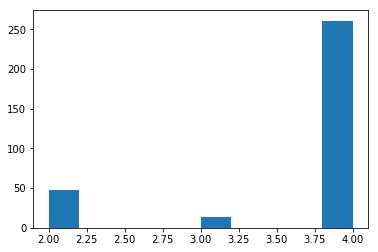

In [3]:
plt.hist(df1.Month)

In [4]:
data=et.matchData(df1,filemap, fdict, start_date, end_date, namfmt, PATH, flen)

In [5]:
data.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,...,i,mod_nitrate,mod_silicon,mod_ammonium,mod_diatoms,mod_ciliates,mod_flagellates,mod_vosaline,mod_votemper,k
0,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,1.6,None,None,None,...,240,20.909998,41.639893,0.634099,0.025693,0.094679,0.189180,29.501553,9.053420,1
1,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,6.2,None,None,None,...,240,20.928925,41.491432,0.628045,0.025080,0.093165,0.185862,29.562063,9.063775,6
2,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,6.2,None,None,None,...,240,20.928925,41.491432,0.628045,0.025080,0.093165,0.185862,29.562063,9.063775,6
3,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,6.2,None,None,None,...,240,20.928925,41.491432,0.628045,0.025080,0.093165,0.185862,29.562063,9.063775,6
4,2015.0,2.0,11.0,5.296111,48.613333,-123.243833,11.4,None,None,None,...,240,20.914087,41.375546,0.624394,0.024558,0.092273,0.183787,29.596073,9.063130,11


In [6]:
# because excludeSaanich was set to false when ran:
data=data.loc[~((data.Lat>48.47)&(data.Lat<48.67)&(data.Lon>-123.6)&(data.Lon<-123.43))].copy(deep=True)

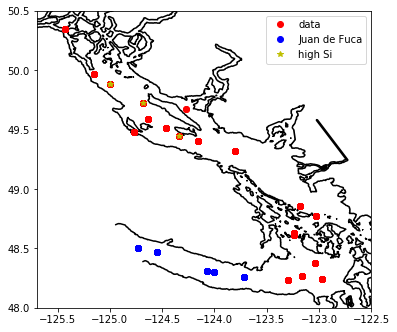

In [7]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
ax.plot(data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lon']], 
        data.loc[(data.Lon < -123.5) & (data.Lat < 48.6),['Lat']], 
        'bo', label = 'Juan de Fuca')

ax.plot(data.loc[data.Si>75,['Lon']],data.loc[data.Si>75,['Lat']],'*',color='y',label='high Si')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

# Nitrate

In [8]:
N_s, modmean_s, obsmean_s, bias_s, RMSE_s, WSS_s = et.stats(data.loc[data.Z<15,['N']],data.loc[data.Z<15,['mod_nitrate']])
N_i, modmean_i, obsmean_i, bias_i, RMSE_i, WSS_i = et.stats(data.loc[(data.Z>=15)&(data.Z<22),['N']],data.loc[(data.Z>=15)&(data.Z<22),['mod_nitrate']])
N_d, modmean_d, obsmean_d, bias_d, RMSE_d, WSS_d = et.stats(data.loc[data.Z>=22,['N']],data.loc[data.Z>=22,['mod_nitrate']])
N, modmean, obsmean, bias, RMSE, WSS = et.stats(data.loc[:,['N']],data.loc[:,['mod_nitrate']])
print('Nitrate')
print('z<15 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_s,bias_s,RMSE_s,WSS_s))
print('15 m<=z<22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_i,bias_i,RMSE_i,WSS_i))
print('z>=22 m:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N_d,bias_d,RMSE_d,WSS_d))
print('all:')
print('  N: {}\n  bias: {}\n  RMSE: {}\n  WSS: {}'.format(N,bias,RMSE,WSS))


Nitrate
z<15 m:
  N: 68
  bias: -1.720918943636562
  RMSE: 4.734853560272922
  WSS: 0.791110259351993
15 m<=z<22 m:
  N: 22
  bias: -2.0677489506114597
  RMSE: 3.586865702664947
  WSS: 0.5614597639064169
z>=22 m:
  N: 204
  bias: -2.9784603672401566
  RMSE: 3.4164714723014904
  WSS: 0.7577335185067617
all:
  N: 294
  bias: -2.6194519727813947
  RMSE: 3.7745427691485793
  WSS: 0.8788259322864378


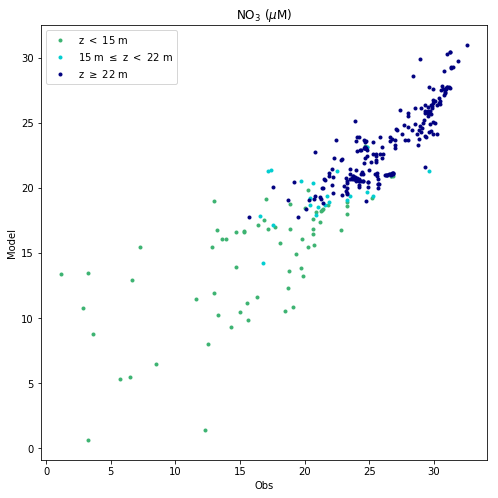

In [9]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'N','mod_nitrate','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

Nitrate, z<15
Feb-Mar:
  N: 8
  bias: -2.786493139266966
  RMSE: 3.8198793172924193
  WSS: 0.7606336169012998
April:
  N: 60
  bias: -1.5788423842191701
  RMSE: 4.843809066120993
  WSS: 0.753989692626028
May-Jun:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
Sep-Oct:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:917: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:918: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


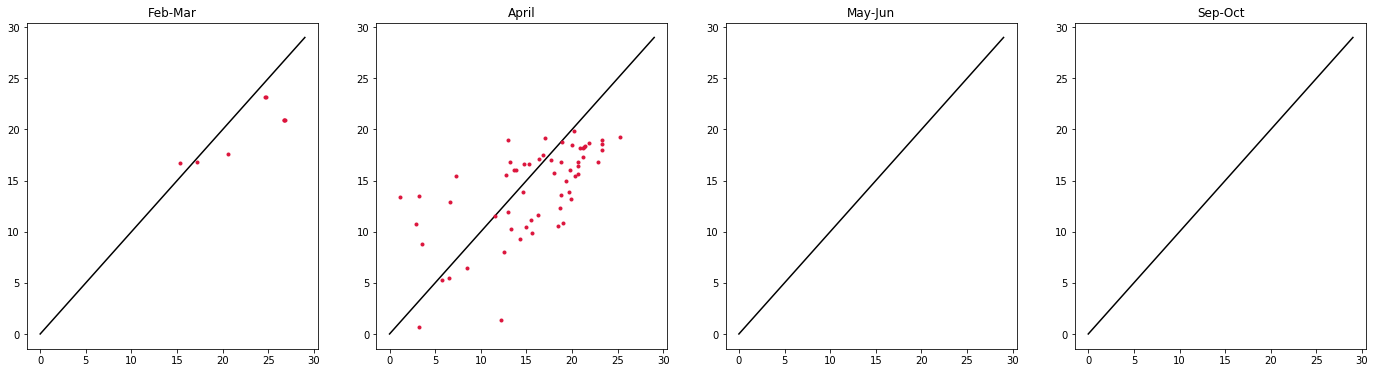

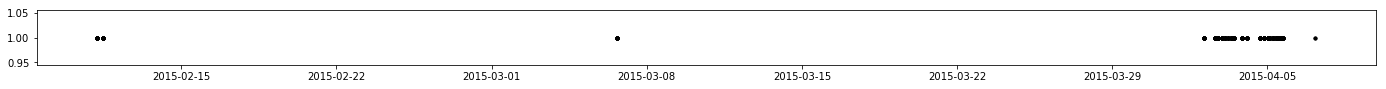

In [10]:
fig, ax = plt.subplots(1,4,figsize = (24,6))
yy=data.dtUTC[0].year
for axi in ax:
    axi.plot(np.arange(0,30),np.arange(0,30),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(yy,4,1)),:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(yy,5,1))&(data.dtUTC>dt.datetime(yy,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(yy,9,1))&(data.dtUTC>dt.datetime(yy,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(yy,12,1))&(data.dtUTC>dt.datetime(yy,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],'N','mod_nitrate',cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

#ii4=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,4,1))&(data.dtUTC>dt.datetime(2016,2,1))
#ps=et.varvarPlot(ax[0],data.loc[ii4,:],obsvar,modvar,cols=('darkturquoise','navy'))
#ii5=(data.Z < 15)&(data.dtUTC<=dt.datetime(2016,5,1))&(data.dtUTC>dt.datetime(2016,4,1))
#ps=et.varvarPlot(ax[1],data.loc[ii5,:],obsvar,modvar,cols=('darkturquoise','navy'))

print('Nitrate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(yy,4,1)),:],'N','mod_nitrate')
print('April:')
et.printstats(data.loc[ii1,:],'N','mod_nitrate')
print('May-Jun:')
et.printstats(data.loc[ii2,:],'N','mod_nitrate')
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],'N','mod_nitrate')
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

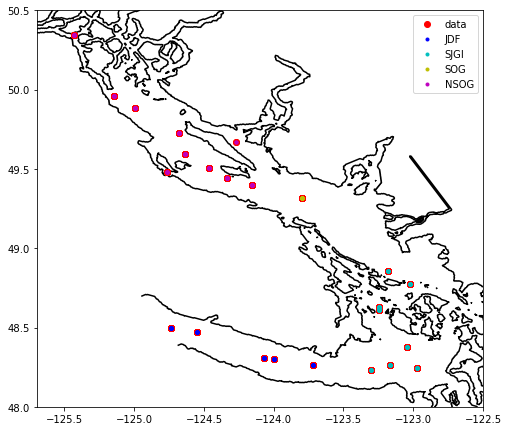

In [11]:
fig, ax = plt.subplots(figsize = (8,8))
viz_tools.set_aspect(ax, coords = 'map')
ax.plot(data['Lon'], data['Lat'], 'ro',label='data')
dJDF=data.loc[(data.Lon<-123.6)&(data.Lat<48.6)]
ax.plot(dJDF['Lon'],dJDF['Lat'],'b.',label='JDF')
dSJGI=data.loc[(data.Lon>=-123.6)&(data.Lat<48.9)]
ax.plot(dSJGI['Lon'],dSJGI['Lat'],'c.',label='SJGI')
dSOG=data.loc[(data.Lat>=48.9)&(data.Lon>-124.0)]
ax.plot(dSOG['Lon'],dSOG['Lat'],'y.',label='SOG')
dNSOG=data.loc[(data.Lat>=48.9)&(data.Lon<=-124.0)]
ax.plot(dNSOG['Lon'],dNSOG['Lat'],'m.',label='NSOG')
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(48, 50.5)
ax.legend()
ax.set_xlim(-125.7, -122.5);

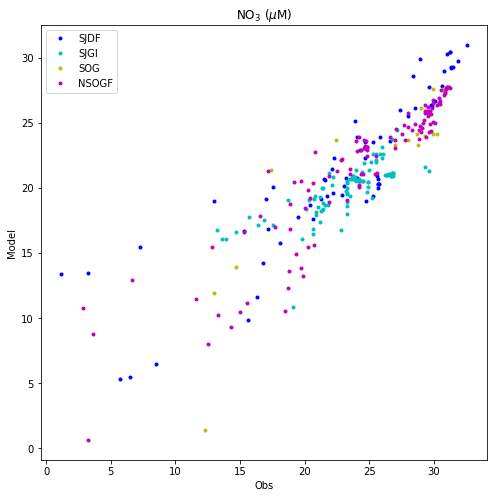

In [12]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,'N','mod_nitrate',cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,'N','mod_nitrate',cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,'N','mod_nitrate',cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,'N','mod_nitrate',cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('NO$_3$ ($\mu$M)')

(-40, 20)

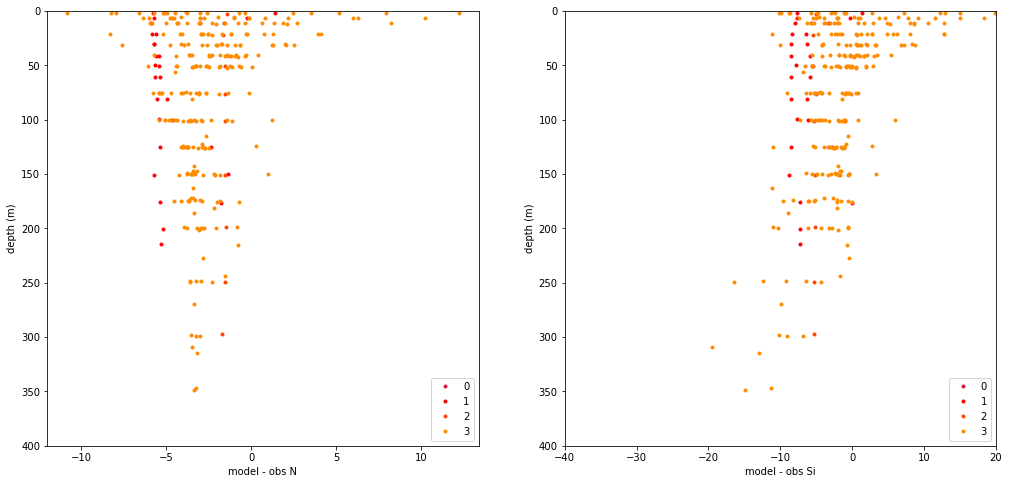

In [13]:
fig, ax = plt.subplots(1,2,figsize = (17,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan','darkturquoise','royalblue',
      'lightskyblue','blue','darkblue','mediumslateblue','blueviolet','darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['N']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(400,0)
    axi.set_ylabel('depth (m)')
ax[0].set_xlabel('model - obs N')
ax[1].set_xlabel('model - obs Si')
ax[1].set_xlim(-40,20)

# Silicate

In [14]:
print('Si')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Si','mod_silicon')
print('15 m<=z<22 m:')
et.printstats(data.loc[(data.Z>=15)&(data.Z<22),:],'Si','mod_silicon')
print('z>=22 m:')
et.printstats(data.loc[data.Z>=22,:],'Si','mod_silicon')
print('all:')
et.printstats(data,'Si','mod_silicon')
print('obs Si < 50:')
et.printstats(data.loc[data.Si<50,:],'Si','mod_silicon')

Si
z<15 m:
  N: 68
  bias: 1.627561657568986
  RMSE: 8.516288669041723
  WSS: 0.8026125026486883
15 m<=z<22 m:
  N: 22
  bias: 0.6061415620283626
  RMSE: 6.108063474455774
  WSS: 0.7026769767613172
z>=22 m:
  N: 204
  bias: -3.111272418452245
  RMSE: 5.22247701252894
  WSS: 0.9159306152152806
all:
  N: 294
  bias: -1.7370417220576257
  RMSE: 6.204174506437927
  WSS: 0.9169394974416084
obs Si < 50:
  N: 230
  bias: -0.36347767116712504
  RMSE: 5.744713828832048
  WSS: 0.8613524704427082


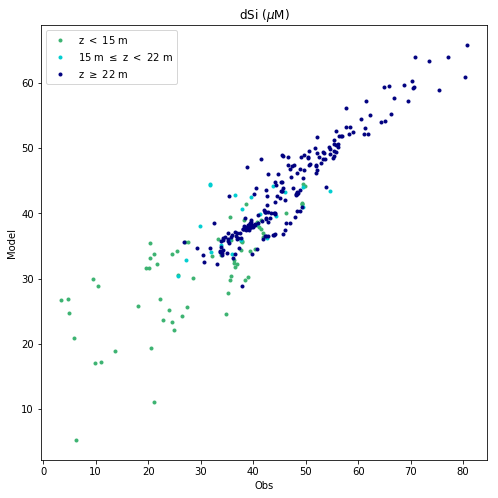

In [15]:
fig, ax = plt.subplots(figsize = (8,8))
ps=et.varvarPlot(ax,data,'Si','mod_silicon','Z',(15,22),'z','m',('mediumseagreen','darkturquoise','navy'))
ax.legend(handles=ps)
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('dSi ($\mu$M)')

Silicate, z<15
Feb-Mar:
  N: 8
  bias: -4.534008998870853
  RMSE: 5.61128655707073
  WSS: 0.8205352665920387
April:
  N: 60
  bias: 2.4491044117609597
  RMSE: 8.831718829138898
  WSS: 0.7643653839442817
May-Jun:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan
Sep-Oct:
  N: 0
  bias: nan
  RMSE: nan
  WSS: nan


/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eolson/anaconda3/envs/python36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:917: RuntimeWarning: invalid value encountered in double_scalars
  RMSE=np.sqrt(np.sum((mod-obs)**2)/N)
/data/eolson/results/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:918: RuntimeWarning: invalid value encountered in double_scalars
  WSS=1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-obsmean)+np.abs(obs-obsmean))**2)


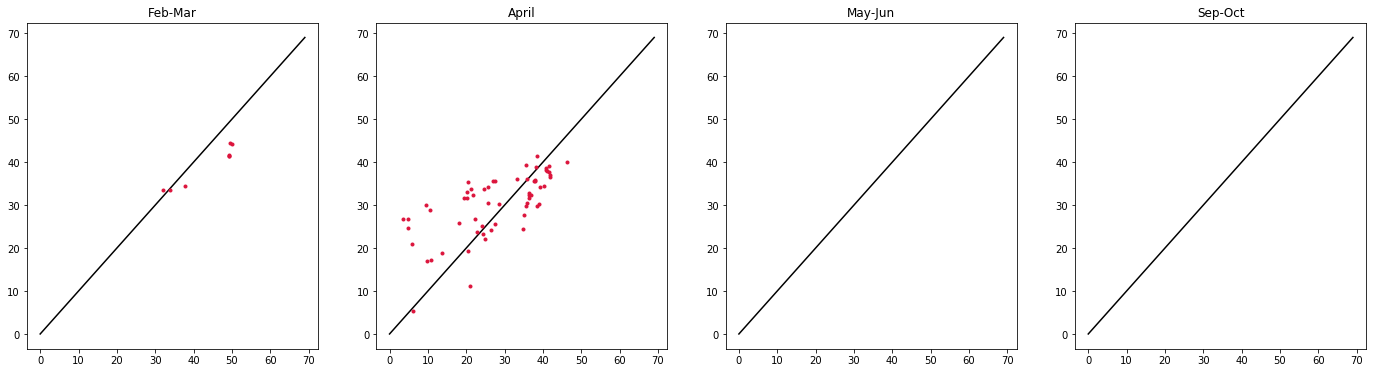

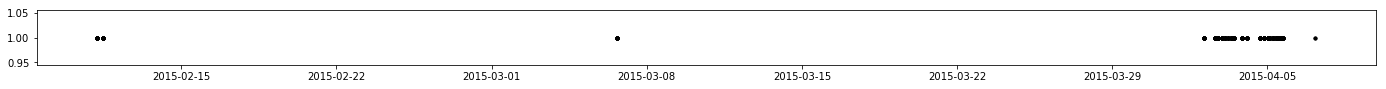

In [16]:
obsvar='Si'; modvar='mod_silicon'
fig, ax = plt.subplots(1,4,figsize = (24,6))
for axi in ax:
    axi.plot(np.arange(0,70),np.arange(0,70),'k-')
ps=et.varvarPlot(ax[0],data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(yy,4,1)),:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[0].set_title('Feb-Mar')
ii1=(data.Z < 15)&(data.dtUTC<=dt.datetime(yy,5,1))&(data.dtUTC>dt.datetime(yy,4,1))
ps=et.varvarPlot(ax[1],data.loc[ii1,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[1].set_title('April')
ii2=(data.Z < 15)&(data.dtUTC<=dt.datetime(yy,9,1))&(data.dtUTC>dt.datetime(yy,5,1))
ps=et.varvarPlot(ax[2],data.loc[ii2,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[2].set_title('May-Jun')
ii3=(data.Z < 15)&(data.dtUTC<=dt.datetime(yy,12,1))&(data.dtUTC>dt.datetime(yy,9,1))
ps=et.varvarPlot(ax[3],data.loc[ii3,:],obsvar,modvar,cols=('crimson','darkturquoise','navy'))
ax[3].set_title('Sep-Oct')

print('Silicate, z<15')
print('Feb-Mar:')
et.printstats(data.loc[(data.Z<15)&(data.dtUTC<=dt.datetime(yy,4,1)),:],obsvar,modvar)
print('April:')
et.printstats(data.loc[ii1,:],obsvar,modvar)
print('May-Jun:')
et.printstats(data.loc[ii2,:],obsvar,modvar)
print('Sep-Oct:')
et.printstats(data.loc[ii3,:],obsvar,modvar)
fig,ax=plt.subplots(1,1,figsize=(24,1))
plt.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')

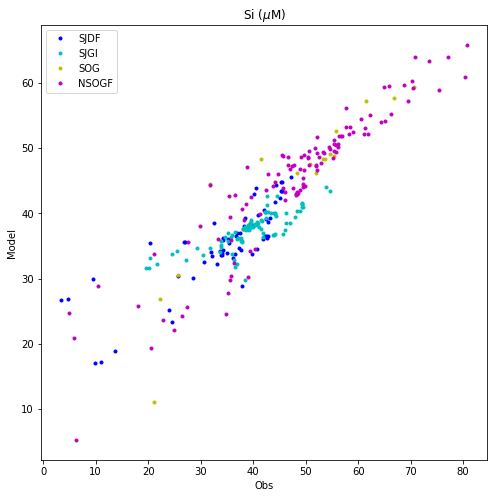

In [17]:
fig, ax = plt.subplots(figsize = (8,8))
ps1=et.varvarPlot(ax,dJDF,obsvar,modvar,cols=('b','darkturquoise','navy'),lname='SJDF')
ps2=et.varvarPlot(ax,dSJGI,obsvar,modvar,cols=('c','darkturquoise','navy'),lname='SJGI')
ps3=et.varvarPlot(ax,dSOG,obsvar,modvar,cols=('y','darkturquoise','navy'),lname='SOG')
ps4=et.varvarPlot(ax,dNSOG,obsvar,modvar,cols=('m','darkturquoise','navy'),lname='NSOGF')
ax.legend(handles=[ps1[0][0],ps2[0][0],ps3[0][0],ps4[0][0]])
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.set_title('Si ($\mu$M)')

# Ratios

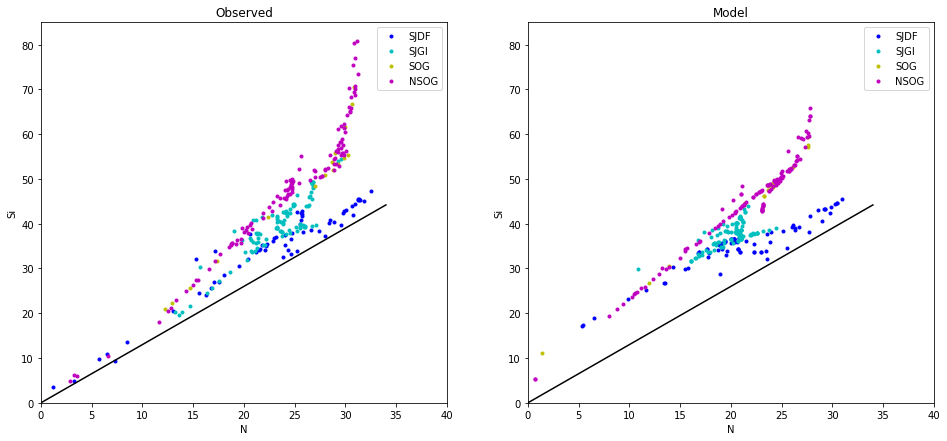

In [18]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['N'],dJDF['Si'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['N'],dSJGI['Si'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['N'],dSOG['Si'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['N'],dNSOG['Si'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('N')
ax[0].set_ylabel('Si')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,85)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_nitrate'],dJDF['mod_silicon'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_nitrate'],dSJGI['mod_silicon'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_nitrate'],dSOG['mod_silicon'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_nitrate'],dNSOG['mod_silicon'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('N')
ax[1].set_ylabel('Si')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,85)
ax[1].legend()
ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

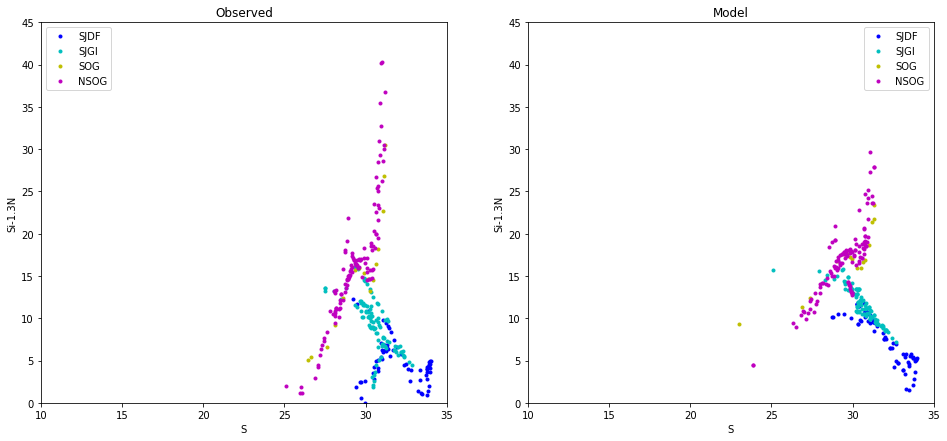

In [19]:
fig,ax=plt.subplots(1,2,figsize=(16,7))
p1=ax[0].plot(dJDF['AbsSal'], dJDF['Si']-1.3*dJDF['N'],'b.',label='SJDF')
p2=ax[0].plot(dSJGI['AbsSal'],dSJGI['Si']-1.3*dSJGI['N'],'c.',label='SJGI')
p3=ax[0].plot(dSOG['AbsSal'],dSOG['Si']-1.3*dSOG['N'],'y.',label='SOG')
p4=ax[0].plot(dNSOG['AbsSal'],dNSOG['Si']-1.3*dNSOG['N'],'m.',label='NSOG')
ax[0].set_title('Observed')
ax[0].set_xlabel('S')
ax[0].set_ylabel('Si-1.3N')
ax[0].set_xlim(10,35)
ax[0].set_ylim(0,45)
ax[0].legend()

p5=ax[1].plot(dJDF['mod_vosaline'],dJDF['mod_silicon']-1.3*dJDF['mod_nitrate'],'b.',label='SJDF')
p6=ax[1].plot(dSJGI['mod_vosaline'],dSJGI['mod_silicon']-1.3*dSJGI['mod_nitrate'],'c.',label='SJGI')
p7=ax[1].plot(dSOG['mod_vosaline'],dSOG['mod_silicon']-1.3*dSOG['mod_nitrate'],'y.',label='SOG')
p8=ax[1].plot(dNSOG['mod_vosaline'],dNSOG['mod_silicon']-1.3*dNSOG['mod_nitrate'],'m.',label='NSOG')
ax[1].set_title('Model')
ax[1].set_xlabel('S')
ax[1].set_ylabel('Si-1.3N')
ax[1].set_xlim(10,35)
ax[1].set_ylim(0,45)
ax[1].legend()

In [20]:
data.loc[data.Si>65,['Month','Lat','Lon','Z','Si']]

,Month,Lat,Lon,Z,Si
212,4.0,49.318833,-123.799667,299.211,66.73
213,4.0,49.318833,-123.799667,346.827,70.58
227,4.0,49.401833,-124.156000,248.711,65.86
228,4.0,49.401833,-124.156000,269.605,70.17
242,4.0,49.443333,-124.337167,248.809,68.77
243,4.0,49.443333,-124.337167,298.713,70.83
244,4.0,49.443333,-124.337167,314.652,77.02
277,4.0,49.591667,-124.637833,162.833,70.41
290,4.0,49.726500,-124.680333,198.888,65.16
291,4.0,49.726500,-124.680333,248.704,69.50


# Chlorophyll

In [21]:
data['l10_obsChl']=np.log10(data['Chlorophyll_Extracted']+0.01)
data['l10_modChl']=np.log10(2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])+0.01)
data['mod_Chl']=2*(data['mod_diatoms']+data['mod_ciliates']+data['mod_flagellates'])

In [22]:
print('log10[Chl+0.01]')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'l10_obsChl','l10_modChl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'l10_obsChl','l10_modChl')
print('all:')
et.printstats(data,'l10_obsChl','l10_modChl')
print('\n')
print('Chl')
print('z<15 m:')
et.printstats(data.loc[data.Z<15,:],'Chlorophyll_Extracted','mod_Chl')
print('z>=15 m:')
et.printstats(data.loc[data.Z>=15,:],'Chlorophyll_Extracted','mod_Chl')
print('all:')
et.printstats(data,'Chlorophyll_Extracted','mod_Chl')


log10[Chl+0.01]
z<15 m:
  N: 44
  bias: 0.0036143752673397644
  RMSE: 0.4877376730198886
  WSS: 0.5369172300526177
z>=15 m:
  N: 20
  bias: -0.029891260618160248
  RMSE: 0.23794397551194876
  WSS: 0.6719023040717187
all:
  N: 64
  bias: -0.006856135946879033
  RMSE: 0.42572402239622675
  WSS: 0.6862241443265591


Chl
z<15 m:
  N: 44
  bias: -0.7050162402912981
  RMSE: 5.043663555804592
  WSS: 0.4894828478023866
z>=15 m:
  N: 20
  bias: -0.13750710287690182
  RMSE: 0.6715195237373195
  WSS: 0.6076330123906892
all:
  N: 64
  bias: -0.5276696348492989
  RMSE: 4.198799345195806
  WSS: 0.5496958691448024


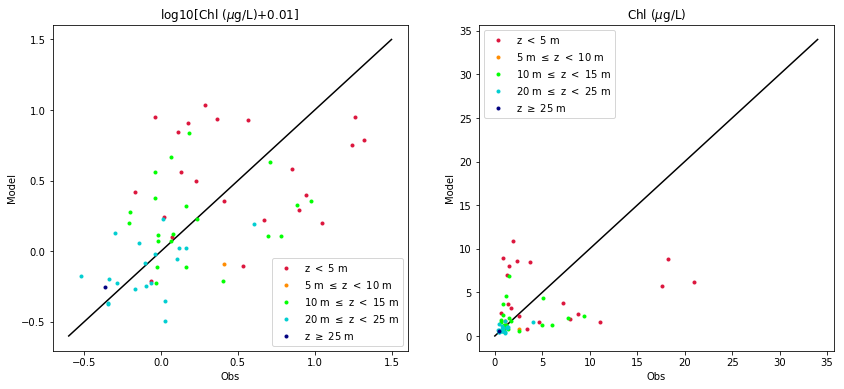

In [23]:
fig, ax = plt.subplots(1,2,figsize = (14,6))
ax[0].plot(np.arange(-.6,1.6,.1),np.arange(-.6,1.6,.1),'k-')
ps=et.varvarPlot(ax[0],data,'l10_obsChl','l10_modChl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[0].legend(handles=ps)
ax[0].set_xlabel('Obs')
ax[0].set_ylabel('Model')
ax[0].set_title('log10[Chl ($\mu$g/L)+0.01]')
ax[1].plot(np.arange(0,35),np.arange(0,35),'k-')
ps=et.varvarPlot(ax[1],data,'Chlorophyll_Extracted','mod_Chl','Z',(5,10,15,20,25),'z','m',('crimson','darkorange','lime','mediumseagreen','darkturquoise','navy'))
ax[1].legend(handles=ps)
ax[1].set_xlabel('Obs')
ax[1].set_ylabel('Model')
ax[1].set_title('Chl ($\mu$g/L)')

In [24]:
fspin=nc.Dataset('/results/SalishSea/spinup.201905/01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc')

In [25]:
ftest=nc.Dataset('/data/eolson/results/MEOPAR/SS36runs/CedarRuns/t15r15LinbfSi/SalishSea_1h_20150101_20150219_ptrc_T_20150101-20150110.nc')

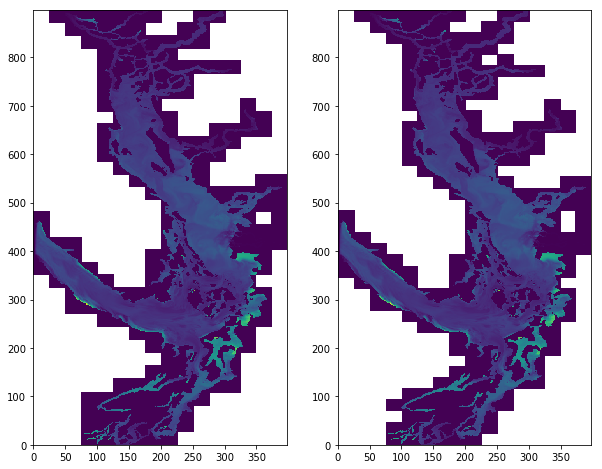

In [26]:
fig,ax=plt.subplots(1,2,figsize=(10,8))
ax[0].pcolormesh(fspin.variables['diatoms'][0,0,:,:])
ax[1].pcolormesh(ftest.variables['diatoms'][0,0,:,:])

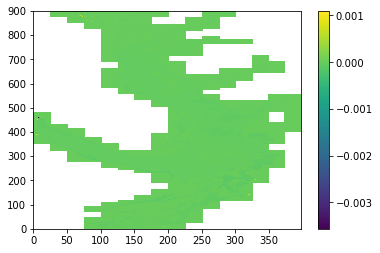

In [27]:
plt.pcolormesh(fspin.variables['diatoms'][0,0,:,:]-ftest.variables['diatoms'][0,0,:,:])
plt.colorbar()

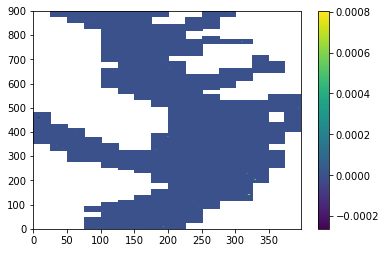

In [28]:
plt.pcolormesh(fspin.variables['microzooplankton'][0,0,:,:]-ftest.variables['microzooplankton'][0,0,:,:])
plt.colorbar()